# 00 Data Profile

Scan raw files, infer columns, and preview missingness.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root():
    cwd = Path().resolve()
    for candidate in (cwd,) + tuple(cwd.parents):
        if (candidate / 'src').is_dir() and (candidate / 'config.yaml').exists():
            return candidate
    return cwd

ROOT = find_repo_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.io import discover_mendeley_files, profile_files, write_data_profile, load_player_daily

raw_dir = ROOT / 'data/raw/mendeley'
discovered = discover_mendeley_files(str(raw_dir))

def print_discovery(label, paths):
    print(f"{label}: {len(paths)}")
    for path in paths[:3]:
        print(f"  - {path}")

print_discovery('PlayerCountHistoryPart1', discovered['player_files_part1'])
print_discovery('PlayerCountHistoryPart2', discovered['player_files_part2'])
if not discovered['player_files_part1'] and not discovered['player_files_part2']:
    print('WARNING: ZIPs likely not extracted.')

print_discovery('PriceHistory', discovered['price_files'])
if not discovered['price_files']:
    print('WARNING: ZIPs likely not extracted.')

print_discovery('Metadata files', discovered['metadata_files'])

files = (
    discovered['player_files_part1']
    + discovered['player_files_part2']
    + discovered['price_files']
    + discovered['metadata_files']
)
profiles = profile_files(files)

missing_rows = []
for profile in profiles:
    for col, miss in profile.get('missingness', {}).items():
        missing_rows.append({'file': profile['path'], 'column': col, 'missing_rate': miss})
missing_df = pd.DataFrame(missing_rows)
if not missing_df.empty:
    display(missing_df.sort_values('missing_rate', ascending=False).head(20))

write_data_profile('reports/data_profile.md', profiles)


PlayerCountHistoryPart1: 1000
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart1\PlayerCountHistoryPart1\10.csv
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart1\PlayerCountHistoryPart1\10090.csv
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart1\PlayerCountHistoryPart1\10180.csv
PlayerCountHistoryPart2: 1000
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart2\PlayerCountHistoryPart2\100.csv
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart2\PlayerCountHistoryPart2\102500.csv
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PlayerCountHistoryPart2\PlayerCountHistoryPart2\102700.csv
PriceHistory: 1512
  - C:\Users\halol\Desktop\steam-discount-impact\data\raw\mendeley\ycy3sy3vj2-1\PriceHistory\Pri

,file,column,missing_rate
2889,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1821,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1891,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
3837,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
3949,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1317,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1331,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1347,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1527,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0
1529,C:\Users\halol\Desktop\steam-discount-impact\d...,playercount,1.0


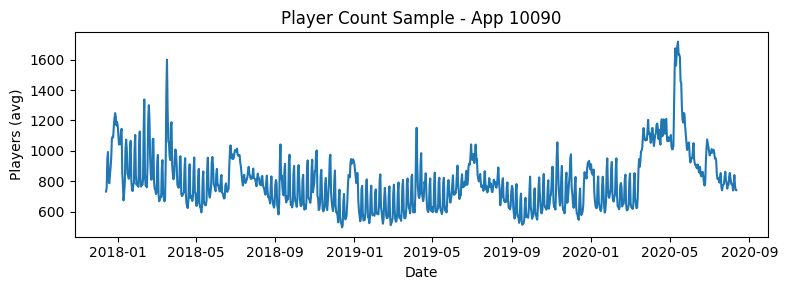

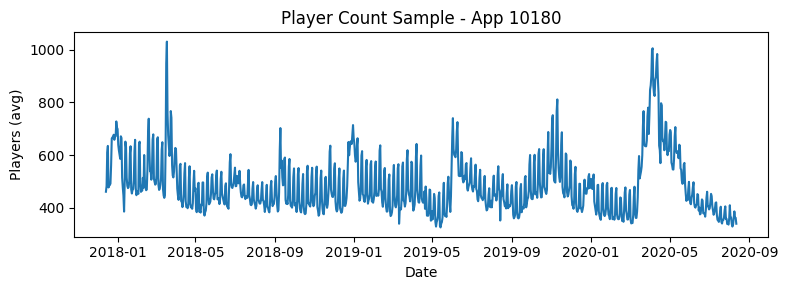

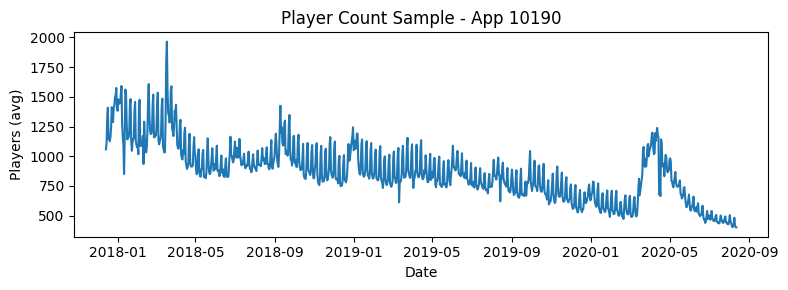

In [2]:
daily, _, _ = load_player_daily(raw_dir, profiles=profiles)
if not daily.empty:
    sample_ids = daily['app_id'].dropna().unique()[:3]
    for app_id in sample_ids:
        subset = daily[daily['app_id'] == app_id]
        plt.figure(figsize=(8, 3))
        plt.plot(subset['date'], subset['player_count'])
        plt.title(f'Player Count Sample - App {int(app_id)}')
        plt.xlabel('Date')
        plt.ylabel('Players (avg)')
        plt.tight_layout()
        plt.show()
